<a href="https://colab.research.google.com/github/avani1998/ECE-6123-Image-and-Video-Processing/blob/main/av3141_IVP_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive 

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(3744, 5616, 3)


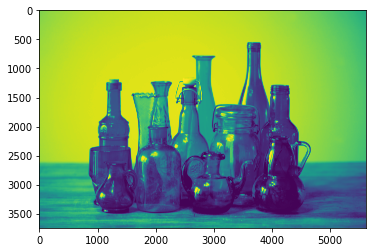

In [2]:
img = cv2.imread("/content/drive/MyDrive/IVP_Assignments/rgb_image.jpeg")
print(img.shape)
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img)

# Problem 1

## (a)
Write functions *gaussian_pyramid* and *laplacian_pyramid* that decompose an input grayscale image into a J-level Gaussian and Laplacian pyramid, respectively, where J is an input to each function.You can use cv2.resize for downsampling and upsampling with INTER_LINEAR and INTER_CUBIC filters, respectively

In [3]:
def gaussian_pyramid(J,img):
  '''
  create J-level gaussian pyramid
  '''
  gp=[]                                             #store gaussian pyramid 
  
  if J>0: 
    y, x = img.shape
    image=img.astype(np.float64)
    gp.append(image)                                #level 0 Original image

    for i in range (J):
      # test if image size = 1x1
      y, x = image.shape
      if x<2 or y<2:
        break
      image = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)              #Gaussian blur
      image = cv2.resize(image,(x//2,y//2),fx=0,fy=0,interpolation=cv2.INTER_LINEAR)
      gp.append(image)
  return gp

In [4]:
levels=gaussian_pyramid(4,img)
for i in levels:
  print(i.shape)

(3744, 5616)
(1872, 2808)
(936, 1404)
(468, 702)
(234, 351)


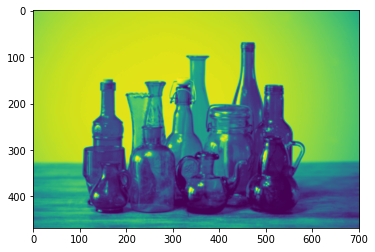

In [5]:
plt.imshow(levels[3])

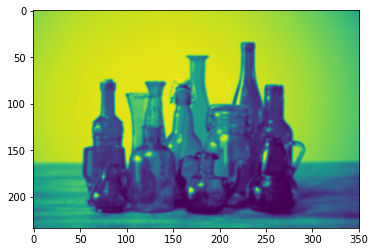

In [6]:
plt.imshow(levels[4])

In [7]:
def laplacian_pyramid(img,J):
  gp = gaussian_pyramid(J,img)
  lp = []                                                           #laplacian pyramid 
  for j in range (len(gp) -1):
    y, x = gp[j].shape
    image = cv2.resize(gp[j+1], (x, y), interpolation=cv2.INTER_CUBIC)
    lp.append(gp[j] - image)
  lp.append(gp[-1])
  return lp

In [8]:
levels=laplacian_pyramid(img,4)
for i in levels:
  print(i.shape)

(3744, 5616)
(1872, 2808)
(936, 1404)
(468, 702)
(234, 351)


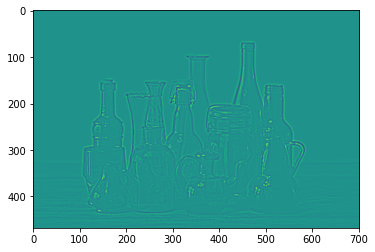

In [9]:
plt.imshow(levels[3])

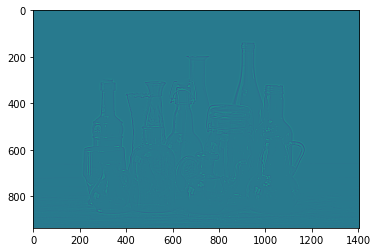

In [10]:
plt.imshow(levels[2])

## (b) 
Write a function *reconstruct_laplacian* that reconstructs the original image from a J-level Laplacian pyramid. Verify it works correctly on a test image. Display the Gaussian and Laplacian pyramid images for J = 3.

In [11]:
def reconstruct_laplacian(lp):
  '''
  reconstructs image from J - level laplacian pyramid
  '''
  reconstruct = lp[-1]
  for j in range(2, len(lp)+1):
    cols, rows = lp[-j].shape
    reconstruct = lp[-j] + cv2.resize(reconstruct, (rows, cols), interpolation=cv2.INTER_CUBIC)
  return reconstruct.astype(np.uint8)

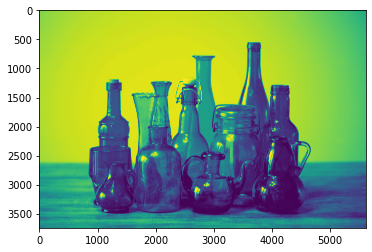

In [12]:
plt.imshow(reconstruct_laplacian(laplacian_pyramid(img,3)))           #verifying it works for test image

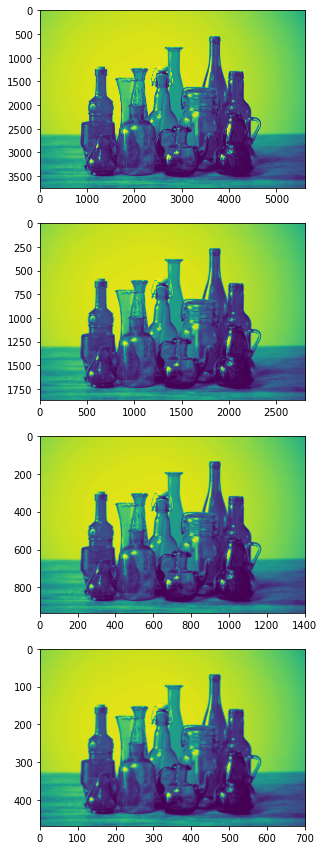

In [13]:
import math
gaussian = gaussian_pyramid(3,img)
laplacian = laplacian_pyramid(img,3)

fig,axes = plt.subplots(4,1, figsize=(15,15))
for i,gimg in enumerate(gaussian):
  axes[i].imshow(gimg)

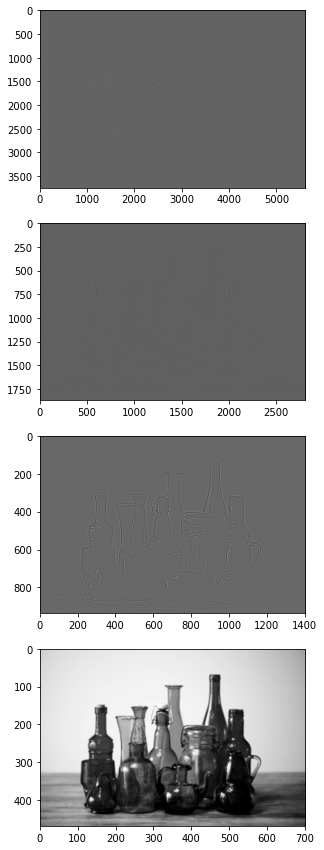

In [14]:
fig,axes = plt.subplots(4,1, figsize=(15,15))
for i,gimg in enumerate(laplacian):
  axes[i].imshow(gimg,cmap='gray')

##(c) 
Write a function *quantize_pyramid* that takes in a Laplacian pyramid and quantizes the coeffcients c with quantization step-size q.

In [15]:
def quantize_pyramid(lp,q):
  quantized_pyramid = []
  mu = 0
  for i in range(len(lp)):
    if i == (len(lp) - 1):                # level 0 of laplacian pyramid is gaussian pyramid level 0 (original image)
      mu = 128
    quaantized_coefficients = q * np.floor((lp[i] - mu) / q + 0.5) + mu
    quantized_pyramid.append(quaantized_coefficients)
  return quantized_pyramid

## (d)

 ## $PSNR = 10 log_{10}(\frac{255^2}{MSE}) $

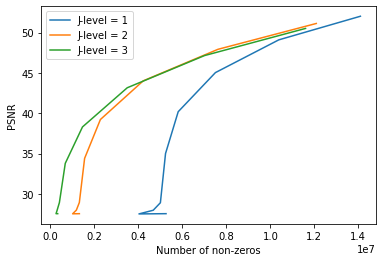

In [16]:
import math
for J in range (1,4):
  lp = laplacian_pyramid(img,J)
  psnr = []
  nnz = [] 
  for q in [2**n for n in range(9)]:
    quantized_pyramid = quantize_pyramid(lp, q)
    nnz.append(sum(np.count_nonzero(ql) for ql in quantized_pyramid))

    reconstructed_img_quant = reconstruct_laplacian(quantized_pyramid)

    mse = np.mean((reconstructed_img_quant - img)**2)
    psnr_img = 10 * math.log10(255 ** 2 / mse)
    psnr.append(psnr_img)
  plt.plot(nnz,psnr,label=f"J-level = {J}")
  plt.xlabel("Number of non-zeros")
  plt.ylabel("PSNR")
  plt.legend()

We see that higher the pyramid depth, higher is the representation efficiency for the image. This is because lesser non-zero values are required to store the image. 

## (e)

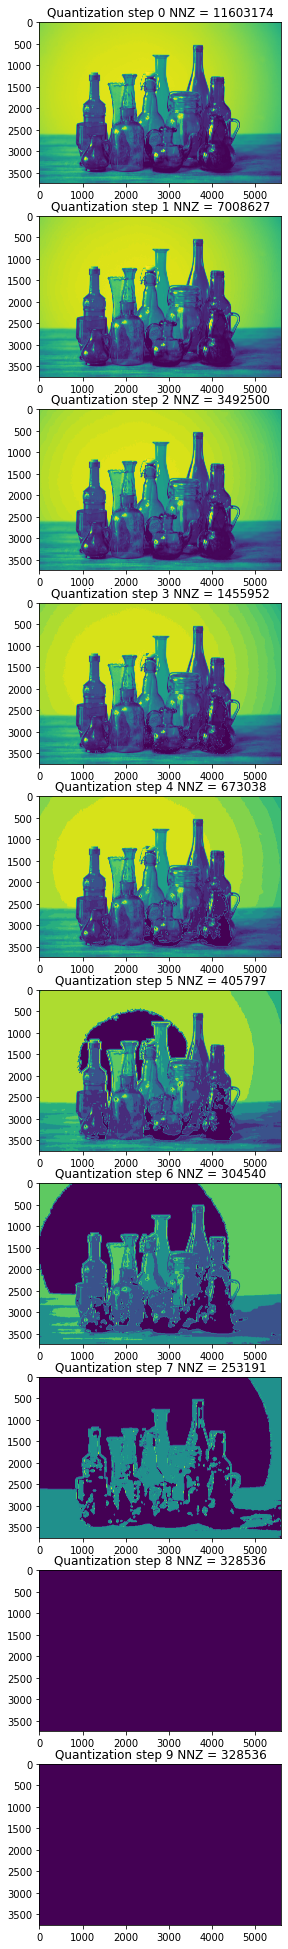

In [30]:
n = 10
Q = np.zeros(n)
lp= laplacian_pyramid(img, 3)
_,ax = plt.subplots(n,1,figsize=(5,35))
for i in range(n):
  Q[i] = 2**i 
  quantized_pyramid = quantize_pyramid(lp, Q[i])
  nnz = sum(np.count_nonzero(ql) for ql in quantized_pyramid)
  ax[i].imshow(reconstruct_laplacian(quantized_pyramid))
  ax[i].set_title(f"Quantization step {str(i)} NNZ = {nnz}")

We can see that the quantization level is relatively unnoticebale till quantization level 5. 

#Problem 2

## (a) 
Use PyWavelet's *dwt2* and *idwt2* to write J-level wavelet transform(*wavelet_transform*) and reconstruction (*reconstruct_wavelet*) functions, for a grayscale input image. Use symmetric boundary conditions.

In [18]:
import pywt

In [19]:
def wavelet_transform(img, J,wavelet_family='haar'):
    wavelet = []
    for j in range(J):
        (img, waveletJ) = pywt.dwt2(img, wavelet_family,mode='sym')
        wavelet.append(waveletJ)
    wavelet.append(img)
    return wavelet

In [20]:
def reconstruct_wavelet(wavelet,wavelet_family='haar'):
    img = wavelet[-1]
    for j in range(2, len(wavelet)+1):
        img = pywt.idwt2((img, wavelet[-j]),wavelet_family,mode='sym')
    return img

## (b) 
Repeat parts (b,c,d,e) from problem 1, now with your wavelet transform functions and wavelet subimages.

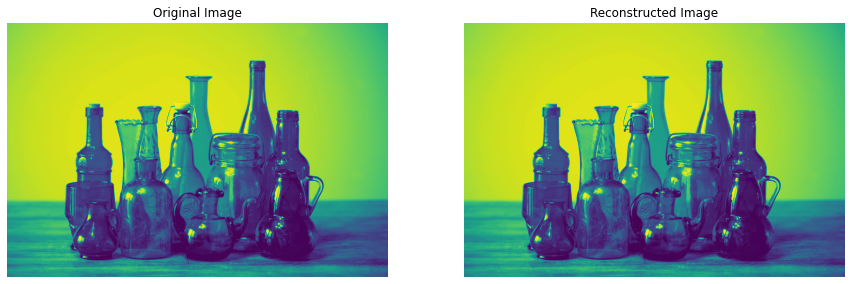

In [21]:
wavelet = wavelet_transform(img, 4)
reconstructed_image = reconstruct_wavelet(wavelet)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.axis("off")
plt.imshow(img)

plt.subplot(1,2,2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.axis("off")

plt.show()

In [24]:
#Quantize wavelet
def quantize_wavelet(wavelet, q):
  quantized_wavelet = []
  mu = 0
  for level in wavelet[:-1]:
    quantized_level = []
    for image in level:
      quantized_coeff = q * np.floor((image - mu) / q + 0.5) + mu
      quantized_level.append(quantized_coeff)
    quantized_wavelet.append(quantized_level)
  quantized_wavelet.append(q * np.floor((wavelet[-1] - 128) / q + 0.5) + 128)
  return quantized_wavelet

[]

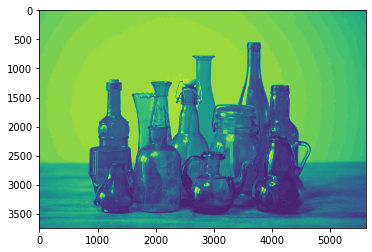

In [25]:
q = quantize_wavelet(wavelet, 128)
r = reconstruct_wavelet(q)

plt.imshow(r)
plt.plot()

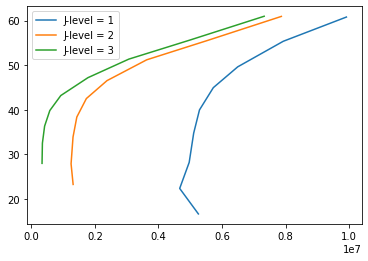

In [26]:
# PSNR
for J in range(1,4):
    wavelet = wavelet_transform(img, J)
    psnr = []
    nnz = [] 
    for q in [2**n for n in range(9)]:
      quantized_wavelet = quantize_wavelet(wavelet, q)
      nnz.append(sum(np.count_nonzero(qw) for qw in quantized_wavelet))

      reconstructed_wavelet=reconstruct_wavelet(quantized_wavelet)
      mse = np.mean((reconstructed_wavelet - img)**2)
      psnr_wavelet = 10 * math.log10(255 ** 2 / mse)

      psnr.append(psnr_wavelet)
    plt.plot(nnz,psnr,label=f"J-level = {J}")
    plt.legend()

We can see that higher the wavelet depth is, higher is the efficiency of representation of the image as fewwe non-zero values are requred to store the image. 

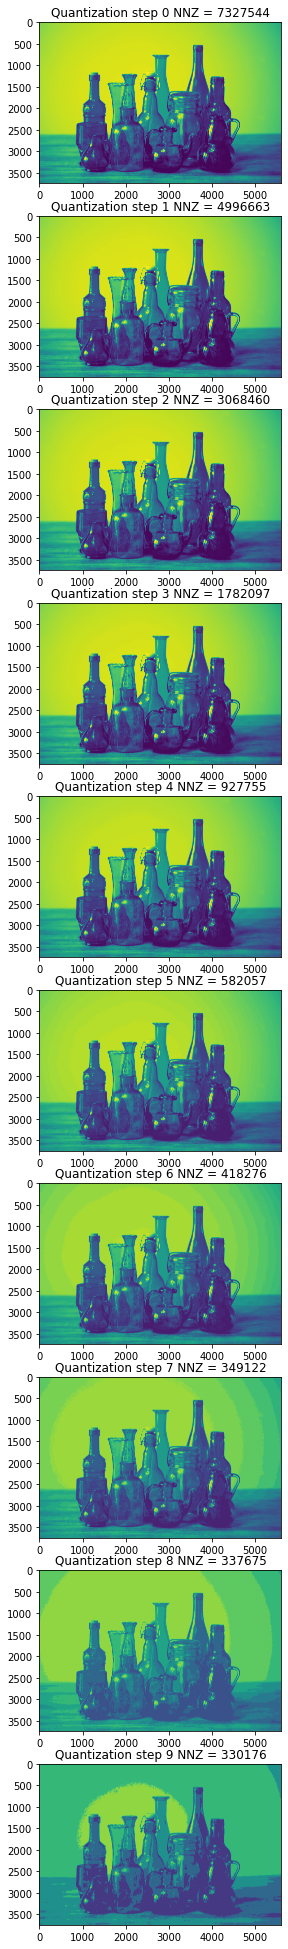

In [31]:
# determining what point quantization level is unnoticeable
n = 10
Q = np.zeros(n)
wavelet= wavelet_transform(img, 3)
_,ax = plt.subplots(n,1,figsize=(5, 35))
for i in range(n):
  Q[i] = 2**i 
  quantized_wavelet = quantize_wavelet(wavelet, Q[i])
  nnz = sum(np.count_nonzero(qw) for qw in quantized_wavelet)
  ax[i].imshow(reconstruct_wavelet(quantized_wavelet))
  ax[i].set_title(f"Quantization step {str(i)} NNZ = {nnz}")

We notice that till quantization step 5, level of quantization is unnoticeable.

## (c) 
Based on your results, compare the representation efficiency of the Laplacian pyramid and wavelet transform in terms of the NNZ required to represent an image to the same quality (PSNR)

Based on the bove results, wavelet transform is more efficient than laplacian transform becuase wavelet transform it is able to store images with lesser number of non-zero values which results in a higher quality reconstruction if the image. Images reconstructed with wavelet transfrom are better looking than images reconstructed by laplacian pyramid transform.